## Name : Abinesh Manivannan
## Student I'd : MAN22604977

### Importing all required libraries :

In [372]:
import os
import cv2
import glob
import math
import json
import shutil
import zipfile
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt


from scipy import stats
from keras.optimizers import Adam
from keras.regularizers import l1
from matplotlib.patches import Ellipse
from tensorflow.keras import regularizers
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture as GMM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation

## Data organizing:

#### Extracting, combining and sorting the data from all the sheets and files :

In [373]:
def extract_zip(file_path, extract_to):
    """
    Extracts the contents of a zip file to a specified directory.
    """
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Files extracted to {extract_to}')

In [374]:
def extract_data_from_sheet(df):
    """
    Extracts and formats data from a given DataFrame representing an Excel sheet.
    """
    sensor_name = df.iloc[0, 1]
    extracted_df = df.iloc[3:].reset_index(drop=True)
    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')
    extracted_df['Sensor Info'] = sensor_name
    return extracted_df

In [375]:
def split_sensor_info(sensor_info):
    """
    Splits the sensor info to extract the sensor ID and sensor name.
    """
    parts = sensor_info.split(' ')
    return pd.Series([parts[0], sensor_info])

In [376]:
def read_all_excel_files(directory):
    """
    Reads and consolidates data from all Excel files in the extraction directory.
    """
    data_frames = []
    excel_files = glob.glob(os.path.join(directory, '**', '*.*'), recursive=True)
    
    for excel_file in excel_files:
        try:
            # Determine the file extension and read the file accordingly
            if excel_file.endswith('.xlsx'):
                xls = pd.ExcelFile(excel_file, engine='openpyxl')
            elif excel_file.endswith('.xls'):
                xls = pd.ExcelFile(excel_file, engine='xlrd')
            else:
                print(f'Skipping non-Excel file: {excel_file}')
                continue
            
            for sheet_name in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet_name)
                extracted_df = extract_data_from_sheet(df)
                data_frames.append(extracted_df)
        
        except Exception as e:
            print(f'Error reading {excel_file}: {e}')
            continue
    
    # Combine all data frames into a single DataFrame
    if data_frames:
        combined_data = pd.concat(data_frames, ignore_index=True)
    
        # Perform operations on combined_data
        combined_data[['Sensor ID', 'Sensor Name']] = combined_data['Sensor Info'].apply(split_sensor_info)
        combined_data = combined_data.drop('Sensor Info', axis=1)
    else:
        combined_data = pd.DataFrame(columns=['Time', 'Temperature', 'Humidity', 'Sensor ID', 'Sensor Name'])
    
    return combined_data

In [377]:
def sort_data(data, keys_list):
    """
    Sorts the DataFrame based on the sensor ID in the given order.
    """
    data['Sensor ID'] = pd.Categorical(data['Sensor ID'], categories=keys_list, ordered=True)
    df_sorted = data.sort_values(by='Sensor ID')
    df_sorted = df_sorted[~pd.isna(df_sorted['Sensor ID'])]
    df_sorted['Sensor ID'] = df_sorted['Sensor ID'].astype(str)
    df_sorted.reset_index(drop=True, inplace=True)
    return df_sorted

In [384]:
# Define the file paths
zip_file_path = 'Data17052024-210552024-1.zip'
extraction_path = 'extracted_files'
sensor_order = [
    "047D6", "0475D", "0479B", "047BB", "04754", "047CE", "047CB",
    "0474D", "04757", "047AA", "047C2", "047F7", "04756", "047C1",
    "0478A", "04762", "04768", "04789", "04773", "047B7", "047D3",
    "047B8", "04750", "0480E", "047DD", "047D7", "047A8", "047BA",
    "047B2", "04804", "04763", "047B6", "047C4", "047D2", "04765",
    "047C8", "0477F", "0478C", "047D4", "0479E", "047C9", "047C7",
    "047CA", "0476E", "0478E", "0475C", "04787", "047AD", "047BC",
    "0475A", "04771", "04791", "04802", "047C5", "04796", "047CD"
]

# Extract zip file
extract_zip(zip_file_path, extraction_path)

# Read all Excel files from the extracted directory
combined_data = read_all_excel_files(extraction_path)
print(f"Combined data shape: {combined_data.shape}")

# Sort the data according to sensor order
sorted_data = sort_data(combined_data, sensor_order)
# print(f"Sorted data shape: {sorted_data.shape}")

Files extracted to extracted_files
Combined data shape: (588879, 5)


In [385]:
sorted_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-10 03:41:57,10.85,83.2,047D6,047D6 T/RH IP67
1,2024-05-02 06:09:22,12.9,94.3,047D6,047D6 T/RH IP67
2,2024-05-02 06:14:20,13.3,93.2,047D6,047D6 T/RH IP67
3,2024-05-02 06:19:20,13.55,93.1,047D6,047D6 T/RH IP67
4,2024-05-02 06:24:22,13.8,92,047D6,047D6 T/RH IP67


In [386]:
sorted_data.tail()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
588249,2024-04-27 22:10:19,11.15,86.9,047CD,047CD T/RH IP67
588250,2024-04-27 22:15:19,11.1,85,047CD,047CD T/RH IP67
588251,2024-04-27 22:20:18,10.9,83.8,047CD,047CD T/RH IP67
588252,2024-04-27 21:45:21,11.4,86.6,047CD,047CD T/RH IP67
588253,2024-05-20 15:41:47,30.5,38.9,047CD,047CD T/RH IP67


## Heatmap video generation :

#### The functions will create heatmap frames and combine them into a vedio.

In [ ]:
def generate_heatmap_frames(sample_dataset, output_dir, sensor_order_dict, column):
    """
    Generates heatmap frames from the dataset and saves them as images in the specified directory.
    """
    sample_dataset[column] = sample_dataset[column].astype(float)

    num_sensors = len(sample_dataset['Sensor ID'].unique())
    range_values = min(100, math.ceil(len(sample_dataset) / num_sensors))  # Ensure we only generate up to 20 frames

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    os.makedirs(output_dir)

    frames = []
    for i in range(1, range_values + 1):
        temp_dataset = sample_dataset.groupby('Sensor ID').nth(-i).reset_index()
        
        # Create an 8x7 matrix for temperature values
        heat_map_data = np.full((8, 7), np.nan)

        for idx, row in temp_dataset.iterrows():
            sensor_id = row['Sensor ID']
            temperature = row[column]
            if sensor_id in sensor_order_dict:
                position = sensor_order_dict[sensor_id]
                row_idx, col_idx = position[0] - 1, position[1] - 1  # Convert to 0-based index
                heat_map_data[row_idx, col_idx] = temperature

        plt.figure(figsize=(10, 6))
        sns.heatmap(heat_map_data, annot=False, cmap="magma", cbar=False, 
                    xticklabels=[f'Col {j+1}' for j in range(7)], 
                    yticklabels=[f'Row {j+1}' for j in range(8)],
                    linewidths=0,  # Remove grid lines
                    linecolor='none')  # Ensure no grid line color

        plt.title(f'Temperature Heat Map for Data Point {20 - i} from Last')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        output_file = os.path.join(output_dir, f"heatmap_{i}.png")
        plt.savefig(output_file)
        plt.close()

        frames.append(output_file)

    return frames

In [ ]:
def generate_video_from_frames(frames, video_output):
    """
    Generates a video from a list of image frames and saves it as an MP4 file.
    """
    if not frames:
        print("No frames to generate video.")
        return
    
    frame = cv2.imread(frames[0])
    height, width, _ = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    video = cv2.VideoWriter(video_output, fourcc, 24.0, (width, height))

    prev_frame = cv2.imread(frames[0])

    for frame_path in frames[1:]:
        next_frame = cv2.imread(frame_path)
        
        for i in range(1, 10):
            alpha = i / 10.0
            interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
            video.write(interpolated_frame)

        prev_frame = next_frame

    video.release()
    cv2.destroyAllWindows()

    print(f"Video saved as: {video_output}")

#### Generating video for temperature

In [387]:
# Define the sensor order for 8x7 matrix
sensor_order_matrix = [
    ["047D6", "0475D", "0479B", "047BB", "04754", "047CE", "047CB"],
    ["0474D", "04757", "047AA", "047C2", "047F7", "04756", "047C1"],
    ["0478A", "04762", "04768", "04789", "04773", "047B7", "047D3"],
    ["047B8", "04750", "0480E", "047DD", "047D7", "047A8", "047BA"],
    ["047B2", "04804", "04763", "047B6", "047C4", "047D2", "04765"],
    ["047C8", "0477F", "0478C", "047D4", "0479E", "047C9", "047C7"],
    ["047CA", "0476E", "0478E", "0475C", "04787", "047AD", "047BC"],
    ["0475A", "04771", "04791", "04802", "047C5", "04796", "047CD"]
]

# Create a dictionary from the sensor order matrix for quick lookup
sensor_order_dict = {sensor: (row_idx + 1, col_idx + 1)
                     for row_idx, row in enumerate(sensor_order_matrix)
                     for col_idx, sensor in enumerate(row)}

# Define the file paths
heatmap_dir = 'New_heatmaps/temperature'
video_output_path = 'Temperature_Heatmap_video.mp4'

# Generate frames for humidity
frames = generate_heatmap_frames(sorted_data, heatmap_dir, sensor_order_dict, 'Temperature')

# Generate video from the frames
generate_video_from_frames(frames, video_output_path)

print(f"Temperature heat maps saved to {heatmap_dir}")

Video saved as: Temperature_Heatmap_video.mp4
Temperature heat maps saved to New_heatmaps/temperature


#### Generating video for humidity

In [388]:
# Define the file paths
heatmap_dir = 'New_heatmaps/humidity'
video_output_path = 'Humidity_Heatmap_video.mp4'

# Generate frames for humidity
frames = generate_heatmap_frames(sorted_data, heatmap_dir, sensor_order_dict, 'Humidity')

# Generate video from the frames
generate_video_from_frames(frames, video_output_path)

print(f"Humidity heat maps saved to {heatmap_dir}")

Video saved as: Humidity_Heatmap_video.mp4
Humidity heat maps saved to New_heatmaps/humidity


## Data Cleaning : 

#### Replacing NaN values using Linear Regression

In [ ]:
def generate_sequences(series, step_size):
    """
    Generate sequences of data for supervised learning.
    """
    input_sequences, target_values = [], []
    for idx in range(step_size, len(series)):
        sequence = series[idx-step_size:idx]
        if not np.isnan(series[idx]) and not np.isnan(sequence).any():
            input_sequences.append(sequence)
            target_values.append(series[idx])
    return np.array(input_sequences), np.array(target_values)

def create_model():
    """
    Create and return a Linear Regression model.
    """
    return LinearRegression()

In [ ]:
def impute_missing_values(df, trained_model, column_name, step_size):
    """
    Impute missing values in the dataset using the trained model.
    """
    df_copy = df.copy()
    column_data = df_copy[column_name].astype(float).values
    for idx in range(step_size, len(column_data)):
        if np.isnan(column_data[idx]):
            input_data = column_data[idx-step_size:idx]
            if np.isnan(input_data).any():
                continue
            input_data = input_data.reshape(1, -1)
            predicted_value = trained_model.predict(input_data)
            column_data[idx] = np.round(predicted_value.item(), 2)
    df_copy[column_name] = column_data
    return df_copy

In [ ]:
def process_and_impute(df, column_name, step_size):
    """
    Train the model on the existing data and impute missing values.
    """
    column_data = df[column_name].astype(float).values
    inputs, targets = generate_sequences(column_data, step_size)
    if len(inputs) == 0 or len(targets) == 0:
        print("Insufficient data to train the model.")
        return df
    
    model = create_model()
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    filled_df = impute_missing_values(df, model, column_name, step_size)
    return filled_df

In [ ]:
# Check for null values in the dataset
def check_null_values(df):
    null_summary = df.isnull().sum()
    total_nulls = null_summary.sum()
    return null_summary, total_nulls

In [389]:
# Usage with sorted_data
null_summary, total_nulls = check_null_values(sorted_data)

print("Null values in each column:\n", null_summary)
print(f"\nTotal null values in the dataset: {total_nulls}")

Null values in each column:
 Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

Total null values in the dataset: 18702


In [390]:
# Fill missing values for 'Temperature'
filled_df = process_and_impute(combined_data, 'Temperature', step_size=5)
print(filled_df.head())

                 Time  Temperature Humidity Sensor ID      Sensor Name
0 2024-04-16 13:05:51        22.80     76.4     0478E  0478E T/RH IP67
1 2024-04-16 13:10:50        23.25     35.3     0478E  0478E T/RH IP67
2 2024-04-16 13:15:48        24.30     39.3     0478E  0478E T/RH IP67
3 2024-04-16 13:20:49        25.20     30.3     0478E  0478E T/RH IP67
4 2024-04-16 13:25:50        24.65     31.5     0478E  0478E T/RH IP67


In [391]:
# Fill missing values for 'Humidity'
filled_df = process_and_impute(filled_df, 'Humidity', step_size=5)

In [392]:
# Ensure sorted_data is sorted according to the sensor order before saving
filled_data_sorted = sort_data(filled_df, sensor_order)

#### Double checking all NaN values are replaced :

In [416]:
# Checkinf for null values in the newly stored dataset

# Usage with filled and sorted data
null_summary, total_nulls = check_null_values(filled_data_sorted)

print("Null values in each column:\n", null_summary)
print(f"\nTotal null values in the dataset: {total_nulls}")

Null values in each column:
 Time           0
Temperature    0
Humidity       0
Sensor ID      0
Sensor Name    0
Anomaly        0
Date           0
dtype: int64

Total null values in the dataset: 0


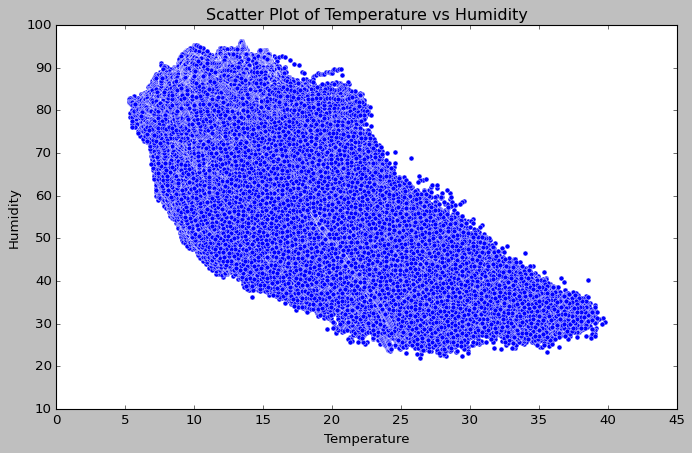

In [393]:
# Filter data to ensure no NaNs in the columns of interest
df_filtered = filled_data_sorted[['Temperature', 'Humidity']].dropna()

plt.style.use('classic') 

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Humidity', data=df_filtered)
plt.title('Scatter Plot of Temperature vs Humidity')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

In [394]:
filled_data_sorted.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-10 03:41:57,10.85,83.2,047D6,047D6 T/RH IP67
1,2024-05-02 06:09:22,12.90,94.3,047D6,047D6 T/RH IP67
2,2024-05-02 06:14:20,13.30,93.2,047D6,047D6 T/RH IP67
3,2024-05-02 06:19:20,13.55,93.1,047D6,047D6 T/RH IP67
4,2024-05-02 06:24:22,13.80,92.0,047D6,047D6 T/RH IP67


In [395]:
filled_data_sorted.tail()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
588249,2024-04-27 22:10:19,11.15,86.9,047CD,047CD T/RH IP67
588250,2024-04-27 22:15:19,11.10,85.0,047CD,047CD T/RH IP67
588251,2024-04-27 22:20:18,10.90,83.8,047CD,047CD T/RH IP67
588252,2024-04-27 21:45:21,11.40,86.6,047CD,047CD T/RH IP67
588253,2024-05-20 15:41:47,30.50,38.9,047CD,047CD T/RH IP67


In [397]:
# # Assuming mean_vector and covariance_matrix are already defined
# mv_normal = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

# # Generate a grid of points to evaluate the distribution
# x_min, x_max = filled_data_sorted['Temperature'].min() - 5, filled_data_sorted['Temperature'].max() + 5
# y_min, y_max = filled_data_sorted['Humidity'].min() - 5, filled_data_sorted['Humidity'].max() + 5

# x, y = np.mgrid[x_min:x_max:0.3, y_min:y_max:0.3]
# pos = np.dstack((x, y))

# # Evaluate the multivariate normal distribution at each grid point
# z = mv_normal.pdf(pos)


# # Plotting the original data
# plt.figure(figsize=(10, 6))
# plt.scatter(filled_data_sorted['Temperature'], filled_data_sorted['Humidity'], alpha=0.5, label='Data')

# # Plotting the fitted Gaussian distribution
# plt.contour(x, y, z, levels=10, cmap='viridis', linewidths=1)
# plt.title('Fitted Multivariate Normal Distribution')
# plt.xlabel('Temperature')
# plt.ylabel('Humidity')
# plt.legend()
# plt.show()

#### Anomaly detection using Gaussian Mixture Model (GMM) :

In [398]:
# Function to plot Gaussian ellipses
def plot_gaussian_ellipses(gmm, ax):
    for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        unit_eigenvector = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
        angle = np.arctan2(unit_eigenvector[1], unit_eigenvector[0])
        angle = np.degrees(angle)
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)

        # Print mean and covariance for each Gaussian distribution
        print(f"Gaussian Component {i+1}:")
        print(f"Mean: {mean}")
        print(f"Covariance:\n{cov}\n")

In [399]:
data = filled_data_sorted[['Temperature', 'Humidity']].dropna().values

# Fit a GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)
labels = gmm.predict(data)

# Create a mesh grid for plotting
x = np.linspace(data[:, 0].min() - 1, data[:, 0].max() + 1, 100)
y = np.linspace(data[:, 1].min() - 1, data[:, 1].max() + 1, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

In [400]:
# Detect anomalies using GMM
log_likelihoods = gmm.score_samples(data)
threshold = np.percentile(log_likelihoods, 5)  # Set the threshold for anomalies
outliers = log_likelihoods < threshold

Gaussian Component 1:
Mean: [13.11918959 79.93826769]
Covariance:
[[12.55278887 -9.11585092]
 [-9.11585092 41.49584677]]

Gaussian Component 2:
Mean: [23.07389497 49.24175362]
Covariance:
[[ 38.50702827 -48.79213871]
 [-48.79213871 123.84550805]]



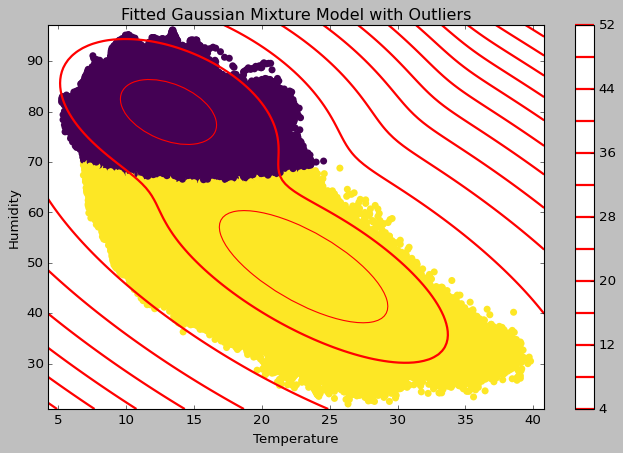

In [401]:
# Plot the results
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=40, marker='o', edgecolor='none')
# plt.scatter(data[outliers, 0], data[outliers, 1], color='red', s=50, marker='x')  # Marking outliers
plt.contour(X, Y, Z, levels=14, linewidths=2, colors='red')
plot_gaussian_ellipses(gmm, ax)
plt.colorbar()
plt.title('Fitted Gaussian Mixture Model with Outliers')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

#### Replacing anamolies using Linear Regression :

In [402]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filled_data_sorted[['Temperature', 'Humidity']])

In [403]:
# Fit GMM
gmm = GMM(n_components=2, covariance_type='full')
gmm.fit(scaled_data)

# Detect anomalies using GMM
log_likelihoods = gmm.score_samples(scaled_data)
threshold = np.percentile(log_likelihoods, 5)  # Set the threshold for anomalies
anomalies_indices = np.where(log_likelihoods < threshold)

In [404]:
# Add an anomaly column: 1 for anomalies, 0 for non-anomalies
filled_data_sorted['Anomaly'] = 0
filled_data_sorted.loc[anomalies_indices[0], 'Anomaly'] = 1

In [405]:
# Split non-anomalous and anomalous data
non_anomalous_data = filled_data_sorted[filled_data_sorted['Anomaly'] == 0]
anomalies_data = filled_data_sorted[filled_data_sorted['Anomaly'] == 1]

In [406]:
# Prepare data for linear regression
X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humid = non_anomalous_data['Humidity']

X_temp_anomalies = anomalies_data[['Temperature']]
X_humid_anomalies = anomalies_data[['Humidity']]

In [407]:
# Fit linear regression model on non-anomalous data for Temperature
temp_reg = LinearRegression()
temp_reg.fit(X_train[['Temperature']], y_train_temp)

LinearRegression()

In [408]:
# Predict Temperature for the anomalies using linear regression
predicted_temp = temp_reg.predict(X_temp_anomalies[['Temperature']])

In [409]:
# Update the anomalies in the original DataFrame with the predicted values for Temperature
filled_data_sorted.loc[anomalies_indices[0], 'Temperature'] = predicted_temp

In [410]:
# Fit linear regression model on non-anomalous data for Humidity
humid_reg = LinearRegression()
humid_reg.fit(X_train[['Humidity']], y_train_humid)

LinearRegression()

In [411]:
# Predict Humidity for the anomalies using linear regression
predicted_humid = humid_reg.predict(X_humid_anomalies[['Humidity']])

In [412]:
# Update the anomalies in the original DataFrame with the predicted values for Humidity
filled_data_sorted.loc[anomalies_indices[0], 'Humidity'] = predicted_humid

print("Anomalies have been replaced with linear regression predicted values.")

Anomalies have been replaced with linear regression predicted values.


#### Plotting data for one day after replacing the anamolies :

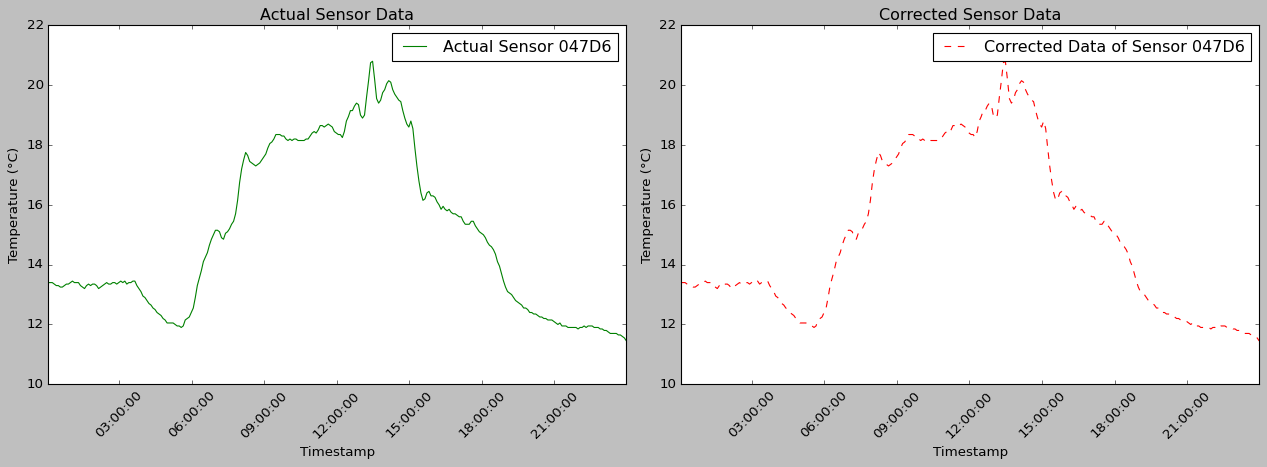

In [413]:
# Set plot style using a valid built-in style
# plt.style.use('classic')  

# Example sensor and date for plotting
sensor_id = '047D6'  # replace with actual sensor ID
date = '2024-05-02'  # replace with actual date

# Assuming 'Time' column is in datetime format
filled_data_sorted['Time'] = pd.to_datetime(filled_data_sorted['Time'])
sorted_data['Time'] = pd.to_datetime(sorted_data['Time'])

# Extracting only the date part for filtering
filled_data_sorted['Date'] = filled_data_sorted['Time'].dt.date
sorted_data['Date'] = sorted_data['Time'].dt.date

# Filter data for the selected sensor and date
filled_data_sensor_day = filled_data_sorted[(filled_data_sorted['Sensor ID'] == sensor_id) & 
                                            (filled_data_sorted['Date'] == pd.to_datetime(date).date())]
sorted_data_sensor_day = sorted_data[(sorted_data['Sensor ID'] == sensor_id) & 
                                     (sorted_data['Date'] == pd.to_datetime(date).date())]

# Ensure the data is sorted by time
filled_data_sensor_day = filled_data_sensor_day.sort_values(by='Time')
sorted_data_sensor_day = sorted_data_sensor_day.sort_values(by='Time')

# Plotting the time series data for Temperature
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot Actual Data
axs[0].plot(sorted_data_sensor_day['Time'], sorted_data_sensor_day['Temperature'], 
            linestyle='-', color='green', label=f'Actual Sensor {sensor_id}')
axs[0].set_title('Actual Sensor Data')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_xlabel('Timestamp')
axs[0].legend()

# Plot Anomaly Data
axs[1].plot(filled_data_sensor_day['Time'], filled_data_sensor_day['Temperature'], 
            linestyle='--', color='red', label=f'Corrected Data of Sensor {sensor_id}')
axs[1].set_title('Corrected Sensor Data')
axs[1].set_ylabel('Temperature (°C)')
axs[1].set_xlabel('Timestamp')
axs[1].legend()

# Rotate the x-axis labels for better readability
for ax in axs:
    plt.sca(ax)  # Set the current axis
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Adjust layout for a cleaner appearance
plt.tight_layout()
plt.show()


#### Saving completely cleaned data for further works :

In [414]:
# Save the filled and sorted data to a new Excel file

filled_output_file = 'Final_data.xlsx'
filled_data_sorted.to_excel(filled_output_file, index=False)

print(f"Filled and sorted data saved to {filled_output_file}")

Filled and sorted data saved to Final_data.xlsx
